<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Little Demo: Catalog Queries with TAP </b> <br>
Contact authors: Gloria Fonseca Alvarez <br>
Last verified to run: 2024-08-12 <br>
LSST Science Pipelines version: Weekly  <br>
Container Size: medium <br>

This little demo shows how to query the DP0.2 catalogs using the TAP service. It is based on DP0.2 notebooks 02a and 02b. 

## 1. Set up

Import python packages and the Rubin Science Platform TAP service.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service, retrieve_query

pandas.set_option('display.max_rows', 20)

Instantiate the TAP service.

In [2]:
service = get_tap_service("tap")

## 2. Explore the TAP schema and table columns.

Create a query to list all of the catalogs in the TAP schema.

In [3]:
query = 'SELECT * FROM tap_schema.schemas'

Run the query.

In [4]:
results = service.search(query)

In [5]:
results

<DALResultsTable length=5>
                                                                                                              description                                                                                                               ...
                                                                                                                 str512                                                                                                                 ...
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ...
             Data Preview 0.1 includes five tables based on the DESC's Data Challenge 2 simulation of 300 square degrees of the wide-fast-deep LSST survey region after 5 years. All tables contain objects detected in coadded images. ...
Data Preview 0.2 contains the

Store the results in an astropy table. 

In [6]:
results = service.search(query).to_table()
results

description,schema_index,schema_name,utype
str512,int32,str64,str512
Data Preview 0.1 includes five tables based on the DESC's Data Challenge 2 simulation of 300 square degrees of the wide-fast-deep LSST survey region after 5 years. All tables contain objects detected in coadded images.,1,dp01_dc2_catalogs,
"Data Preview 0.2 contains the image and catalog products of the Rubin Science Pipelines v23 processing of the DESC Data Challenge 2 simulation, which covered 300 square degrees of the wide-fast-deep LSST survey region over 5 years.",0,dp02_dc2_catalogs,
ObsCore v1.1 attributes in ObsTAP realization,2,ivoa,
A TAP-standard-mandated schema to describe tablesets in a TAP 1.1 service,100000,tap_schema,
UWS Metadata,120000,uws,


List the tables in the DP0.2 catalogs.

In [7]:
query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" \
        "ORDER BY table_index ASC"
results = service.search(query).to_table()

In [8]:
results

description,schema_name,table_index,table_name,table_type,utype
str512,str512,int32,str64,str8,str512
Properties of the astronomical objects detected and measured on the deep coadded images.,dp02_dc2_catalogs,1,dp02_dc2_catalogs.Object,table,
"Properties of detections on the single-epoch visit images, performed independently of the Object detections on coadded images.",dp02_dc2_catalogs,2,dp02_dc2_catalogs.Source,table,
"Forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the Object table. Point-source PSF photometry is performed, based on coordinates from a reference band chosen for each Object and reported in the Object.refBand column.",dp02_dc2_catalogs,3,dp02_dc2_catalogs.ForcedSource,table,
Properties of time-varying astronomical objects based on association of data from one or more spatially-related DiaSource detections on individual single-epoch difference images.,dp02_dc2_catalogs,4,dp02_dc2_catalogs.DiaObject,table,
Properties of transient-object detections on the single-epoch difference images.,dp02_dc2_catalogs,5,dp02_dc2_catalogs.DiaSource,table,
"Point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the DiaObject table.",dp02_dc2_catalogs,6,dp02_dc2_catalogs.ForcedSourceOnDiaObject,table,
"Metadata about the pointings of the DC2 simulated survey, largely associated with the boresight of the entire focal plane.",dp02_dc2_catalogs,7,dp02_dc2_catalogs.Visit,table,
Metadata about the 189 individual CCD images for each Visit in the DC2 simulated survey.,dp02_dc2_catalogs,8,dp02_dc2_catalogs.CcdVisit,table,
Static information about the subset of tracts and patches from the standard LSST skymap that apply to coadds in these catalogs,dp02_dc2_catalogs,9,dp02_dc2_catalogs.CoaddPatches,table,


List all the columns in the Object table.

In [9]:
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'dp02_dc2_catalogs.Object'"
results = service.search(query).to_table()

In [10]:
results

column_name,datatype,description,unit
str64,str64,str512,str64
coord_dec,double,Fiducial ICRS Declination of centroid used for database indexing,deg
coord_ra,double,Fiducial ICRS Right Ascension of centroid used for database indexing,deg
deblend_nChild,int,Number of children this object has (defaults to 0),
deblend_skipped,boolean,Deblender skipped this source,
detect_fromBlend,boolean,This source is deblended from a parent with more than one child.,
detect_isDeblendedModelSource,boolean,True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not a sky source and is a deblended child,
detect_isDeblendedSource,boolean,True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not a sky source and is either an unblended isolated source or a deblended child from a parent with,
detect_isIsolated,boolean,This source is not a part of a blend.,
detect_isPatchInner,boolean,True if source is in the inner region of a coadd patch,


List all the columns in the ForcedSource table.

In [11]:
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'dp02_dc2_catalogs.ForcedSource'"
results = service.search(query).to_table()

In [12]:
results

column_name,datatype,description,unit
str64,str64,str512,str64
band,char,Abstract filter that is not associated with a particular instrument,
ccdVisitId,long,Unique ID of visit and detector for which forced photometry was performed. Primary Key of the CcdVisit Table.,
coord_dec,double,Fiducial ICRS Declination of Object centroid used for database indexing,deg
coord_ra,double,Fiducial ICRS Right Ascension of Object centroid used for database indexing,deg
detect_isPatchInner,boolean,True if Object seed is in the inner region of a coadd patch,
detect_isPrimary,boolean,True if Object seed has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not a sky object,
detect_isTractInner,boolean,True if Object seed is in the inner region of a coadd tract,
forcedSourceId,long,Unique ID of forced source. Primary Key.,
localBackground_instFlux,double,Background in annulus around source,count


## 3. Query the Object table.

Define the coordinates and radius for a spatial search. 

In [13]:
center_ra = 62
center_dec = -37
radius = 0.01

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

In [14]:
query = "SELECT objectId, coord_ra, coord_dec, g_cModelFlux, g_cModelFluxErr "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"

In [15]:
results = service.search(query).to_table()
results

objectId,coord_ra,coord_dec,g_cModelFlux,g_cModelFluxErr
,deg,deg,nJy,nJy
int64,float64,float64,float64,float64
1651228970407963050,61.9892581,-37.0051185,326.5138376,14.2705104
1651220174314940169,61.9974384,-37.0057962,514.36525,18.512609
1651220174314940145,62.0032855,-37.0062479,199.6395648,20.4148871
1651220174314940105,61.9982376,-37.0071231,190.5018125,13.5239014
1651220174314940327,62.0033408,-37.0025362,259.3417025,13.4338853
1651220174314940222,62.0087858,-37.0048004,261.1045021,17.07974
1651220174314940054,62.0067606,-37.008115,67.2192719,15.9486801
1651220174314943124,61.9996415,-37.0073422,62.1849027,12.8999188


Increase the search radius and run an asynchronous query.

In [16]:
del results

In [17]:
center_ra = 62
center_dec = -37
radius = 0.5

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

In [18]:
query = "SELECT objectId, coord_ra, coord_dec, g_cModelFlux, g_cModelFluxErr "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"

In [19]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
#job.raise_if_error()

Job phase is COMPLETED


In [20]:
results = job.fetch_result().to_table()
results

objectId,coord_ra,coord_dec,g_cModelFlux,g_cModelFluxErr
,deg,deg,nJy,nJy
int64,float64,float64,float64,float64
1651413688361452486,61.9633337,-36.5130381,87.0327531,11.427506
1651413688361453181,61.8924527,-36.507808,30.5953283,13.6635788
1651413688361452920,61.8884207,-36.5091517,33.0829193,11.0448069
1651413688361452919,61.8877113,-36.5090904,195.5987974,15.9109814
1651413688361452918,61.8870687,-36.5091254,150.4294078,13.244513
1651413688361452889,61.9196129,-36.5086578,11.6068281,12.7490609
1651413688361452888,61.9195084,-36.5091561,276.7016293,15.5864475
1651413688361452887,61.9173006,-36.5112305,130.0196026,12.2823882


Convert fluxes to magnitudes using the function scisql_nanojanskyToAbMab and scisql_nanojanskyToAbMagSigma.

In [21]:
query = "SELECT coord_ra, coord_dec, "\
        "-2.5 * LOG10(g_cModelFlux) + 31.4 AS gmag1, "\
        "scisql_nanojanskyToAbMag(g_cModelFlux) AS gmag2, "\
        "scisql_nanojanskyToAbMagSigma(g_cModelFlux, g_cModelFluxErr) AS gmag2err "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"

In [22]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [23]:
results = job.fetch_result().to_table()
results

coord_ra,coord_dec,gmag1,gmag2,gmag2err
deg,deg,,,
float64,float64,float64,float64,float64
61.9633337,-36.5130381,26.5507931956459,26.5507931956459,0.1425584800245823
61.8924527,-36.507808,27.685862205725982,27.685862205725982,0.4848793268129645
61.8884207,-36.5091517,27.600990436134484,27.600990436134484,0.36247547011041437
61.8877113,-36.5090904,25.671584549281953,25.671584549281953,0.08831919617524803
61.8870687,-36.5091254,25.956668135477894,25.956668135477894,0.09559332506053851
61.9196129,-36.5086578,28.738216118800864,28.738216118800864,1.1925839580407214
61.9195084,-36.5091561,25.29497070899695,25.29497070899695,0.06115891112431494
61.9173006,-36.5112305,26.114977914247937,26.114977914247937,0.10256479240795674


Get the g, r, and i magnitudes for point-like sources.

In [24]:
query = "SELECT objectId, "\
        "scisql_nanojanskyToAbMag(g_psfFlux) AS gmag, "\
        "scisql_nanojanskyToAbMag(r_psfFlux) AS rmag, "\
        "scisql_nanojanskyToAbMag(i_psfFlux) AS imag "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 0 "\
        "AND g_extendedness = 0 "\
        "AND r_extendedness = 0 "\
        "AND i_extendedness = 0"

In [25]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [26]:
results = job.fetch_result().to_table()
#results

Plot a color-color diagram.

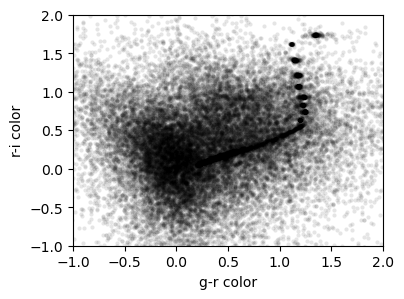

In [27]:
fig = plt.figure(figsize=(4, 3))
plt.plot(results['gmag']-results['rmag'], results['rmag']-results['imag'],
         'o', mew=0, ms=3, alpha=0.1, color='black')
plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.xlabel('g-r color')
plt.ylabel('r-i color')
plt.show()

In [28]:
query = "SELECT objectId, "\
        "scisql_nanojanskyToAbMag(g_psfFlux) AS gmag, "\
        "scisql_nanojanskyToAbMag(r_psfFlux) AS rmag, "\
        "scisql_nanojanskyToAbMag(i_psfFlux) AS imag "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 0 "\
        "AND g_extendedness = 0 "\
        "AND r_extendedness = 0 "\
        "AND i_extendedness = 0 "\
        "AND i_psfFlux/i_psfFluxErr > 5 "\
        "AND z_psfFlux/z_psfFluxErr > 5 "\
        "AND y_psfFlux/y_psfFluxErr > 5" 

In [29]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [30]:
results = job.fetch_result().to_table()
#results

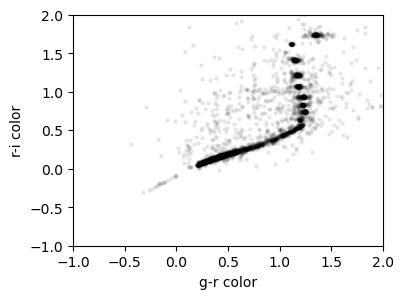

In [31]:
fig = plt.figure(figsize=(4, 3))
plt.plot(results['gmag']-results['rmag'], results['rmag']-results['imag'],
         'o', mew=0, ms=3, alpha=0.1, color='black')
plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.xlabel('g-r color')
plt.ylabel('r-i color')
plt.show()

## 4. Query the ForcedSource and CCD Visit tables.

Start with a known objectID. This is a variable star.

In [32]:
str_target_objectId = '1651589610221899038'

Query using a table join. 

In [33]:
query = "SELECT fs.objectId, fs.forcedSourceID, "\
        "cv.ccdVisitId, cv.band "\
        "FROM dp02_dc2_catalogs.ForcedSource AS fs "\
        "JOIN dp02_dc2_catalogs.CcdVisit AS cv ON fs.ccdVisitId = cv.ccdVisitId "\
        "WHERE fs.objectId = " + str_target_objectId

In [34]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [35]:
results = job.fetch_result().to_table()
results

objectId,forcedSourceID,ccdVisitId,band
int64,int64,int64,object
1651589610221899038,222726828119327111,414861046,r
1651589610221899038,385912535351589577,718818112,r
1651589610221899038,506443285447858497,943324129,r
1651589610221899038,506443828224344173,943325140,r
1651589610221899038,222743471654445561,414892047,r
1651589610221899038,387532245365179276,721835057,r
1651589610221899038,404589149635508257,753606017,r
1651589610221899038,385933419093201114,718857011,r
1651589610221899038,506013745768597725,942524049,r


Plot the i-band lightcurve.

In [36]:
query = "SELECT fs.objectId, fs.forcedSourceID, "\
        "scisql_nanojanskyToAbMag(fs.psfFlux) AS mag, "\
        "scisql_nanojanskyToAbMagSigma(fs.psfFlux, fs.psfFluxErr) AS magerr, "\
        "cv.band, cv.expMidptMJD "\
        "FROM dp02_dc2_catalogs.ForcedSource AS fs "\
        "JOIN dp02_dc2_catalogs.CcdVisit AS cv ON fs.ccdVisitId = cv.ccdVisitId "\
        "WHERE fs.objectId = " + str_target_objectId + "  "\
        "AND cv.band = 'i'"

In [37]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [38]:
results = job.fetch_result().to_table()
results

objectId,forcedSourceID,mag,magerr,band,expMidptMJD
,,,,,d
int64,int64,float64,float64,object,float64
1651589610221899038,653477216797103764,18.395204578235376,0.003786831536750768,i,61371.2830422
1651589610221899038,351361092728938838,18.165696081114035,0.0032559799225709246,i,60549.2712432
1651589610221899038,113571894833197927,17.96861837100967,0.003043382751798176,i,59866.3557842
1651589610221899038,553335157491261255,18.271534232535394,0.004081229566019974,i,61098.0866502
1651589610221899038,650665002671305832,18.454571457928836,0.0038163756224843517,i,61364.1963772
1651589610221899038,650664556531574217,18.44978365331655,0.0038163310491518294,i,61364.1959242
1651589610221899038,650690850858240156,18.45726065335482,0.0038979549711981288,i,61364.2191292
1651589610221899038,115167969104926801,18.43833607064463,0.0035704157814200207,i,59870.2435682


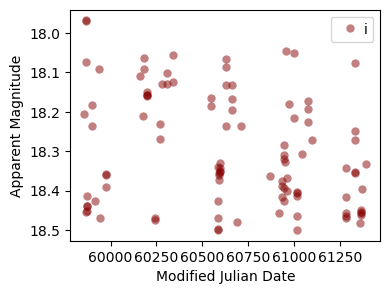

In [39]:
fig = plt.figure(figsize=(4, 3))
plt.plot(results['expMidptMJD'], results['mag'],'o', color='#850000', alpha=0.5, mew=0, label='i')
plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date')
plt.ylabel('Apparent Magnitude')
plt.legend(loc='upper right', handletextpad=0)
plt.show()